In [51]:
from ipywidgets import VBox, HBox, Layout, interactive_output, FloatSlider, FloatText
from ipywidgets import interactive as interactive_ipyw

from brian2 import * #type: ignore
import NeuronEquations
import BrianHF
import numpy as np

import matplotlib.pyplot as plt
# NOTE: HAVING NO RESET v=vr CAUSES MORE SPIKES TO OCCUR AS THERE IS NO INTEGRATION TIME NEEDED TO REACH THRESHOLD!!!!!!

In [52]:
# Assuming NeuronEquations.EQ_SCM_IF and BrianHF.calculate_ChebyshevNeighbours are defined elsewhere
def simulate_neurons_interactive(tau, vt, vr, beta, W_Exc, W_Inh, run_time, timeStep):
    start_scope()
    defaultclock.dt = timeStep*ms

    grid_size_x = 5 # Number of neurons in the x direction
    grid_size_y = 5
    N_Neurons = grid_size_x * grid_size_y # Number of neurons\
        
        
    # Neuron Equation
    Eqs_Neurons = NeuronEquations.EQ_SCM_IF

    # Neuron Parameters
    Neuron_Params = {'tau': tau*ms, 'vt': vt, 'vr': vr, 'P': 0, 'incoming_spikes': 0, 'method': 'exact'}
    # Synapse Parameters
    Syn_Params = {'Num_Neighbours' :8, 'beta': beta, 'W_Exc': W_Exc, 'W_Inh': W_Inh}
    Num_Neighbours = Syn_Params['Num_Neighbours']

    input = []
    # Input generation
    for i in range (5):
        input.extend(range(i, N_Neurons, 5))
    times = []
    for i in range(5):
        times.extend([(i**1.3)]*5)
    
    G_Spikes = SpikeGeneratorGroup(N_Neurons, input, times*ms)

    neuronsGrid = NeuronGroup(N_Neurons, Eqs_Neurons, threshold='v>vt',
                            reset='''
                            v = vr
                            incoming_spikes_post = 0
                            ''',
                            refractory='0*ms',
                            events={'P_ON': 'v > vt', 'P_OFF': '(timestep(t - lastspike, dt) > timestep(dt, dt) and v <= vt)'},
                            namespace=Neuron_Params)
    
    neuronsGrid.set_event_schedule('P_ON', when = 'after_thresholds')
    neuronsGrid.run_on_event('P_ON', 'P = 1' , when = 'after_thresholds')
    neuronsGrid.set_event_schedule('P_OFF', when = 'groups')
    neuronsGrid.run_on_event('P_OFF', 'P = 0', when = 'groups')

    # # Generate x and y values for each neuron
    # x_values = np.repeat(np.arange(grid_size_x), grid_size_y)
    # y_values = np.tile(np.arange(grid_size_y), grid_size_x)

    # # Assign x, y, and z values to each neuron
    # neuronsGrid.X = x_values
    # neuronsGrid.Y = y_values

    # Creating the synapses
    Syn_Input_Neurons = Synapses(G_Spikes, neuronsGrid,
                                 'beta : 1 (constant)',
                                 on_pre='''
                                 ExtIn_post = beta
                                 ''',
                                 namespace=Syn_Params)

    Syn_Neurons_Neurons = Synapses(neuronsGrid, neuronsGrid,
                               '''
                               W_Exc : 1
                               W_Inh : 1
                               ''',
                               on_pre={'pre': 'incoming_spikes_post += 1; Exc_pre = W_Exc',
                                   'pre_2' : 'Inh_post = P_post * W_Inh / incoming_spikes_post'},
                               namespace=Syn_Params)

    '''
    Various options for the Inh weight update:
    IN USE: Inh_post = P_post * W_Inh * incoming_spikes_post
    Inh_post = clip(P_post * (W_Inh/incoming_spikes_post), W_Inh, 0)
    Inh_post += clip(P_post * (W_Inh/incoming_spikes_post), W_Inh, 0)
    Inh_post = P_post * (W_Inh/incoming_spikes_post)
    Inh_post += P_post * (W_Inh/incoming_spikes_post)
    '''

    # SYNAPSE CONNECTIONS:
    # Connect the first synapses from input to neuronsGrid on a 1 to 1 basis
    Syn_Input_Neurons.connect(j = 'i')
    Syn_Input_Neurons.beta = beta

    # Unzip the pairs into two lists
    indexes_i, indexes_j = BrianHF.calculate_Neighbours(neuronsGrid, Num_Neighbours)
    # Connect the last group of synapses from a neuron to its neighbors
    Syn_Neurons_Neurons.connect(i=indexes_i, j=indexes_j)
    Syn_Neurons_Neurons.W_Inh = W_Inh
    Syn_Neurons_Neurons.W_Exc = W_Exc

    # SETTING UP MONITORS:
    # Monitor the spikes
    SpikeMon_Input = SpikeMonitor(G_Spikes, when= 'after_thresholds')
    SpikeMon_Neurons = SpikeMonitor(neuronsGrid, when='after_thresholds')
    
    # RUNNING THE SIMULATION:
    # display(scheduling_summary())
    BrianLogger.log_level_error()
    run(run_time)
    
    return SpikeMon_Input, SpikeMon_Neurons

def update_plot(timeStep, beta, W_Exc, W_Inh):
    run_time = 30*ms
    tau = 0.2
    vt = 0.1
    vr = 0.0
    # Run the simulation W_Excth the current slider values
    SpikeMon_Input, SpikeMon_Neurons = simulate_neurons_interactive(tau, vt, vr, beta, W_Exc, W_Inh, run_time, timeStep)
    
    plt.figure(figsize=(10, 10))
    plt.subplot(211)
    plt.plot(SpikeMon_Input.t/ms, SpikeMon_Input.i, '.k')
    plt.xlim(-0.5, run_time/ms+0.5)
    # plt.xticks(np.arange(-0.0, run_time/ms, 0.5))
    plt.title('Input spikes')
    plt.xlabel('Time (ms)')
    plt.ylabel('Neuron index')
    
    # plt.subplot(312)
    # plt.plot(SpikeMon_Neurons.t/ms, SpikeMon_Neurons.i, '.k')
    # delay_out = 0
    # if SpikeMon_Neurons.num_spikes > 0:
    #     delay_out = +SpikeMon_Neurons.t[0]/ms
    #     plt.plot(SpikeMon_Input.t/ms+delay_out, SpikeMon_Input.i, 'xr')
    # plt.legend(['Model Output Spikes', 'Original Input spikes\n + integration delay of {:.2f} ms'.format(delay_out)], loc='upper right')
    # plt.xlim(-0.5, run_time/ms+0.5)
    # # plt.xticks(np.arange(-0.0, run_time/ms, 0.5))
    # plt.title('Neuron Grid spikes')
    # plt.xlabel('Time (ms)')
    # plt.ylabel('Neuron index')
    
    unique_neurons = np.unique(SpikeMon_Neurons.i)
    colors = plt.cm.Dark2(np.linspace(0, 1, len(unique_neurons)))  # Generate a color map

    plt.subplot(212)
    legend_handles = []
    for neuron, color in zip(unique_neurons, colors):
        neuron_spikes = SpikeMon_Neurons.t[SpikeMon_Neurons.i == neuron] / ms
        plt.plot(neuron_spikes, np.full(neuron_spikes.shape, neuron), '.', color=color)
    legend_handles.append(Line2D([0], [0], marker='.', color='k', linestyle='None', label='Model Output Spikes'))

    delay_out = 0
    if SpikeMon_Neurons.num_spikes > 0:
        delay_out = +SpikeMon_Neurons.t[0]/ms
        plt.plot(SpikeMon_Input.t/ms+delay_out, SpikeMon_Input.i, 'xr')
    legend_handles.append(Line2D([0], [0], marker='x', color='r', linestyle='None', label='Original Input spikes\n + integration delay of {:.2f} ms'.format(delay_out)))

    plt.legend(handles=legend_handles, loc='upper right')
    plt.xlim(-0.5, run_time / ms + 0.5)
    # plt.xticks(np.arange(-0.0, run_time / ms, 0.5))
    plt.title('Neuron Grid spikes')
    plt.xlabel('Time (ms)')
    plt.ylabel('Neuron index')
    
    plt.tight_layout()
    plt.savefig('output_image.png')

In [53]:
# Create sliders for parameters
timeStep = FloatText(value=0.5, description='timeStep:', step=0.01, min=0.0, max=1.0, continuous_update=False, readout_format='.3f')
# tau_slider = FloatSlider(min=0.01, max=5, step=0.01, value=0.2, description='tau', continuous_update=False)
# vt_slider = FloatSlider(min=0.01, max=1.0, step=0.01, value=0.1, description='vt', continuous_update=False)
# vr_slider = FloatSlider(min=0.0, max=1.1, step=0.1, value=0.0, description='vr', continuous_update=False)
beta_slider = FloatSlider(min=0.0, max=10.0, step=0.00001, value=0.5, description='beta', continuous_update=False, readout_format='.5f')
W_Exc_slider = FloatSlider(min=0.0, max=10.0, step=0.00001, value=6.0, description='W_Exc', continuous_update=False, readout_format='.5f')
W_Inh_slider = FloatSlider(min=-10.0, max=0.0, step=0.00001, value=-3.0, description='W_Inh', continuous_update=False, readout_format='.5f')

# Display the interactive plot
# Create a dictionary of sliders

# Create a dictionary of sliders
# sliders = {
#     'tau': tau_slider,
#     'vt': vt_slider,
#     'vr': vr_slider,
#     'beta': beta_slider,
#     'W_Exc': W_Exc_slider,
#     'W_Inh': W_Inh_slider
# }

widgets = {
    'timeStep': timeStep,
    'beta': beta_slider,
    'W_Exc': W_Exc_slider,
    'W_Inh': W_Inh_slider,
}

In [54]:
# # Use the ** operator to unpack the dictionary into keyword arguments
# interactive_plot = interactive_ipyw(update_plot, **widgets)
# output = interactive_plot.children[-1]
# # output.layout.height = '600px' # Adjust the height of the output area
# # Create a Label W_Excdget W_Excth vertical space (adjust the number of <br> tags as needed)

# # Assuming plot_layout and sliders_layout are defined as before
# plot_layout = VBox([output])  # The plot itself is already arranged vertically
# sliders_layout = VBox([timeStep, beta_slider, W_Exc_slider, W_Inh_slider])

# # Combine the plot and sliders (now W_Excth added space) side by side W_Excth the sliders on the right
# interactive_layout = HBox([plot_layout, sliders_layout])
# interactive_layout.layout.align_items = 'center'
# # Display the combined layout
# display(interactive_layout)

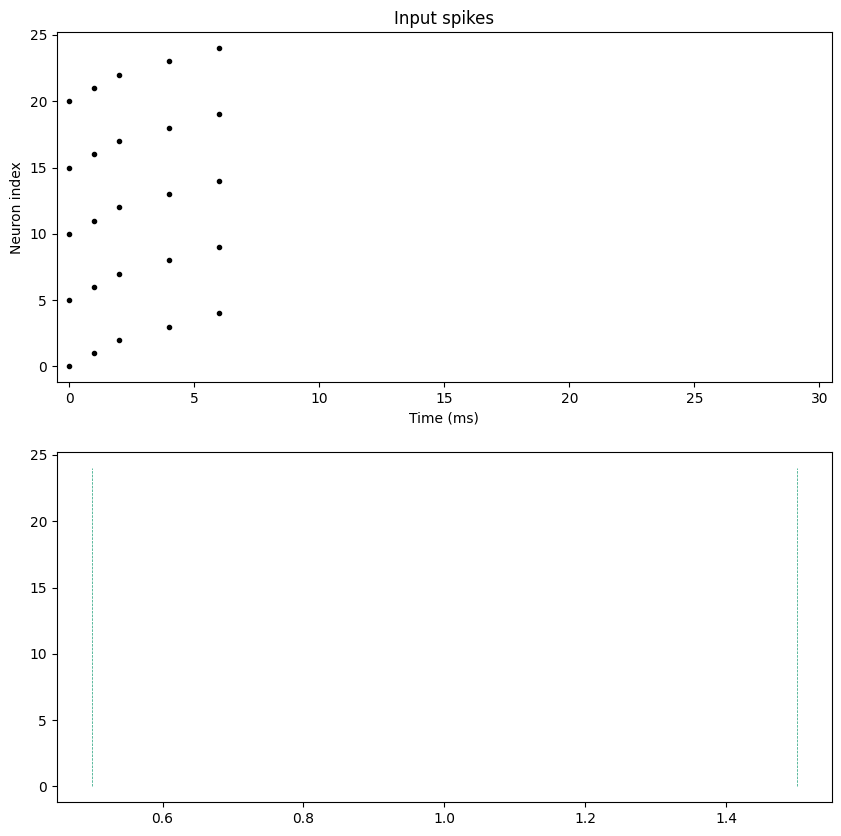

In [55]:
from ipywidgets import VBox, HBox, HTML

# Use the ** operator to unpack the dictionary into keyword arguments
interactive_plot = interactive_ipyw(update_plot, **widgets)
output = interactive_plot.children[-1]
# output.layout.height = '600px' # Adjust the height of the output area

# Create an HTML widget with vertical space (adjust the number of <br> tags as needed)
vertical_space = HTML(value='<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>')

# Assuming plot_layout and sliders_layout are defined as before
plot_layout = VBox([output])
sliders_layout = VBox([timeStep, beta_slider, W_Exc_slider, W_Inh_slider])

# Combine the plot and sliders with added space side by side with the sliders on the right
interactive_layout = HBox([plot_layout, VBox([vertical_space, sliders_layout])])
interactive_layout.layout.align_items = 'center'

# Display the combined layout
display(interactive_layout)